In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import phantom_builder
from core import *
import open3d as o3d
from open3d import io, visualization

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import functools


In [3]:

voxel_size = np.array([0.00058984, 0.00058984, 0.0005])
surface_mesh = io.read_triangle_mesh("../demos/breast_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [4]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=1)
fat = tissue.Tissue(name='fat', c=1440.2, rho=911, sigma=0, scale=1, label=2)
ligament = tissue.Tissue(name='ligament', c=1750, rho=1142, sigma=30, scale=0.0001, label=3)
gland = tissue.Tissue(name='gland', c=1564, rho=1041, sigma=40, scale=0.0001, label=4)

kidney_file_dir = "../demos/breast_files/"
kidney_tissue_list = [skin, fat, ligament, gland, gland]

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('fat')

In [44]:
test_phantom.mask = np.flip(test_phantom.mask, axis=0)
test_phantom.matrix_dims = np.array(test_phantom.mask.shape)
test = test_phantom.get_complete()


In [45]:
print(body_mask.shape)

(219, 306, 193)


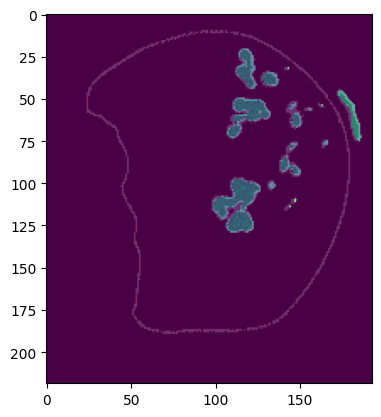

In [46]:
slice =60
plt.imshow(test[0, :, slice, :])
bm = np.flip(body_mask, axis=0)
plt.imshow(bm[:,slice, :] * 1000, alpha=0.2, cmap='Reds_r')